# Introduction -- Reminder

Each Python lab will start with a pre-flight exercise that walks through building some of the set up and tools ($\sim$ 30 min), followed by an in-class tutorial with time for Q+A (50 min) so you can walk through steps that will be necessary for the homework assignment you will submit ($\sim$ 3 hrs).  Each lab will contain starter code, similar to what you see below.  Please fill in the code to complete the pre-flight assignment in preparation for the in-class tutorial.  

Preflight ($\sim$30-60 min, 10 points) **Typically due: Wednesdays 3pm EST**

*Preflight typically graded by Wednesday 5p EST*

In-class tutorial and Q+A ($\sim$ 50 min, 10 points) **Typically occurs: Thursdays 9am EST**

Homework assignment ($\sim$ 3-5 hrs, 30 points) **Typically due: Mondays 9am EST** 

*Homework typically graded by Thursday 5p*

When we grade your homework, we will not run your code. Once submitted, your notebook should have the outputs for all of your results.  Please do not include long outputs from debugging, beyond a few print statements and the requested visualizations (i.e. plots).

**Grading:** When we grade your notebook, we will convert the .ipynb file to an HTML file.  We will be using [nbgrader](https://nbgrader.readthedocs.io/en/stable/) to grade your notebooks.  **Note:** If your ```IPython``` version is too old, we will *not* be able to grade your assignments.


# Phys 260 Python Lab 3: Boundary conditions (20 points total)

## Tutorial summary
- Method of relaxation for setting the potential with boundary conditions
- Plotting a scalar field (e.g. the potential V)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Brief review
- Taking derivatives on a grid
- Extension to 2d

## Background of application (quick review of the vector calculus between $\vec{E}$ and V)

In class you saw, 
\begin{equation}
\vec E = - \vec \nabla V, ~~~~~~~~ ~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (1) }
\end{equation}
where $\vec \nabla = \left(\frac{\partial}{\partial x},\frac{\partial}{\partial y},\frac{\partial}{\partial z}\right)$ in cartesian coordinates,
 and 
 \begin{equation}
\vec E = \int \frac {\rho d\tau} {4 \pi \epsilon_0}\frac {\hat r} {r^2}.~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (2) }
\end{equation}
Here $d\tau$ is the differential volume element (e.g. $d\tau=dxdydz$) to avoid confusion with $V$ which is the potential.

Equation (2) is an integral equation.  The inverse of integration is taking a derivative.  Taking the divergence of both sides of Equation (2), we arrive at the differential form of Gauss' law:

\begin{equation}
\vec \nabla \cdot \vec E = \frac \rho {\epsilon_0}. ~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (3) }
\end{equation}

If we now substitute Equation (1) into this equation we get: 
\begin{equation}
\nabla^2 V= \frac {- \rho} {\epsilon_0}.~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (4) }
\end{equation}

It might help to write out how this works out in Cartesian coordinates in case the nabla-notation is new to you:

\begin{equation}
\vec{\nabla}_{\mathrm{cart}}=\left[\frac{\delta}{\delta x},\frac{\delta}{\delta y}, \frac{\delta}{\delta z}\right]
=\left[\delta_x,\delta_y,\delta_z\right] = \delta_x\hat{i} + \delta_y\hat{j} + \delta_z\hat{k}
\end{equation}

Expressing the electric field in terms of the potential, we have,
\begin{equation}
\vec{E} = -\vec{\nabla}_{\mathrm{cart}}V=-\left[\frac{\delta V}{\delta x},\frac{\delta V}{\delta y}, \frac{\delta V}{\delta z}\right]
=-\left[\delta_xV,\delta_yV,\delta_zV\right] = -\delta_xV\hat{i} - \delta_yV\hat{j} - \delta_zV\hat{k} = E_x\hat{i}+E_y\hat{j}+E_z\hat{k}
\end{equation}

And, explicitly writing out equation (3):
\begin{equation}
\vec \nabla \cdot \vec E = \delta_xE_x+\delta_yE_y+\delta_zE_z = \frac \rho {\epsilon_0}. 
\end{equation}

And, explicitly writing out equation (4) in cartesian coordinates:
\begin{equation}
\left(\vec \nabla \cdot (-\vec{\nabla}V\right) = \left[\delta_x,\delta_y,\delta_z\right] \cdot \left[-\delta_xV,-\delta_yV,-\delta_zV\right] = -\left(\delta_x^2V + \delta_y^2V + \delta_z^2V\right) = -\nabla^2 V,
\end{equation}
so, 
\begin{equation}
\nabla^2V = -\frac{\rho}{\epsilon_0}
\end{equation}
where, $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}$.

This simplifies when we restrict ourselves to the case where we are considering the potential in regions where there are absolutely no charges (e.g., $\rho = 0$).  Then we have:
\begin{equation}
\nabla^2 V= 0.  ~~~~~~~~ ~~~~~~~~ ~~~~~~~~ \mbox{  (5) }
\end{equation}
Equation 5 is just saying that the second derivative of the potential $V$ is zero in regions where there are no charges.  If this were one dimensional then this would mean that the potential can have slopes and nothing more complicated that that.    

A TLDR: The ingredients for Equation 5:
- Coulomb's law, Equation (2) and (3) with the integral and differential forms
- The definition of the potential, Equation (1) 
- The choice that we will only consider regions that are charge free.  

Assuming our problem satisfies condition (c) then Equation 5 completely specifies the electric field and is equivalent to solving Coulomb's law.  Of course you need Equation (1) to recover the field.   You might think that (c) is a big restriction, but it isn't.  You just carefully cut out the regions that have charges, figure out the potential on the boundary of the regions you had to remove and then plug ahead with (5).   


The generalization of this statement to 2 and 3 dimensions will lend itself to a very easy numerical method for solving for the potential.  We'll come back to this in the next section.

In [47]:
# Set up a 2-d grid with np.meshgrid: a 4x8 rectangle, with 80 points per value
x_position, y_position = np.meshgrid(np.linspace(-4,4,80), np.linspace(-2,2,40), indexing='ij')
potential = np.zeros(x_position.shape)

Below, we plot the position points that we are sampling, where the the points sampled were generated from `np.meshgrid`. 

x varies across bottom edge and has shape:  (80,)
x varies across top edge and has shape:  (80,)
y varies across left edge and has shape:  (40,)
y varies across right edge and has  shape:  (40,)


Text(0,0.5,'y [m]')

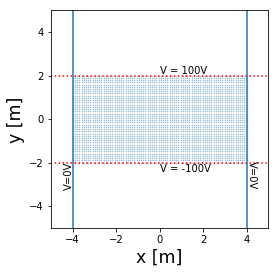

In [63]:
print('x varies across bottom edge and has shape: ', potential[:,0].shape)
print('x varies across top edge and has shape: ', potential[:,-1].shape)
print('y varies across left edge and has shape: ', potential[0,:].shape)
print('y varies across right edge and has  shape: ', potential[-1,:].shape)

# Visualization of points sampled
plt.scatter(x_position, y_position, s=0.2, alpha=0.5)
plt.xlim(-5,5)

# Horizontal lines
plt.axhline(-2, xmin=-5,xmax=5, c='r', ls=':')
plt.axhline(2, xmin=-5,xmax=5, c='r', ls=':')

# Vertical lines
plt.axvline(-4, ymin=-5,ymax=5)
plt.axvline(4, ymin=-5,ymax=5)

# Label what we will want to happen
plt.annotate('V = 100V', (0, 2.1))
plt.annotate('V = -100V', (0, -2.4))

plt.annotate('V=0V', (-4.4,-2.3), rotation=90)
plt.annotate('V=0V', (4.,-2.3), rotation=-90)

plt.ylim(-5,5)
plt.gca().set_aspect('equal')
plt.xlabel('x [m]', fontsize='xx-large')
plt.ylabel('y [m]', fontsize='xx-large')

**Group exercise** (5 min): Recall, you can set values in an array.  Let us create an array of zeros, `example_edge_conditioned_array` using `np.zeros`, with shape (10,1).  Let us set the first and last elements of `example_edge_conditioned_array` equal to 1. 

In [30]:
# Define example_edge_array here
### BEGIN SOLUTION
example_edge_conditioned_array = np.zeros((10,1))
example_edge_conditioned_array[0] = 1
example_edge_conditioned_array[-1] = 1
### END SOLUTION

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [29]:
"""Execute to check you're on the right track"""
assert(example_edge_conditioned_array.shape == (10,1))
### BEGIN HIDDEN TESTS
test_conditioned_array = np.zeros((10,1))
test_conditioned_array[0] = 1
test_conditioned_array[-1] = 1
assert((example_edge_conditioned_array == test_conditioned_array).all())
### END HIDDEN TESTS

Analogous to what we did for a 1-d array, `example_edge_conditioned_array`, let us do the same thing for a 2-d array, `potential`.  We wish to set boundary conditions such that:
```
x_edges = 0
y_edge_top = 100
y_edge_bottom
```

In [ ]:
# Impose boundary conditions


# Phys 260 Python Lab 3: Effects of Discretization and the Efield from the potential (10 points total)


Your homework assignment begins here.  Note, the homework below relies on code built during the tutorial (above)


## Homework summary 
- Plotting the electric field with the method of relaxation
- Practice writing functions and slicing arrays with "Effects of discretization:  Example with Gauss' Law"

## Effects of discretization: Example with Gauss' Law

## Gauss' law due to a spherical insulator

Gauss' law states that a closed surface has a total flux equal to the charge enclosed.  We will write a function, `calc_efield_sphere_gauss` that calculates the electric field due to an insulating sphere that we discussed in the tutorial portion, e.g. the And compare with the numerical calculation from discretized charge in the tutorial.

In [5]:
# Let's first define our field points, points_in_meshgrid

In [6]:
# Let's define our charge points

In [7]:
# Let's define our functions that calculate the efield due to an array of charges

In [2]:
def calc_efield_sphere_gauss(points_in_meshgrid, sphere_radius=1, Q=1) :
    '''
    
    '''
    
### BEGIN SOLUTION
    pass
### END SOLUTION

## Compare the Gauss' law (exact) calculation to the discretized version (2 points)

Take the function, `calc_efield_sphere_gauss`, and calculate the electric field for `points_in_meshgrid`, `efield_sphere_gauss`.    

In [3]:
#  Calculate efield_sphere_gauss here
### BEGIN SOLUTION
efield_sphere_gauss = calc_efield_sphere_gauss(points_in_meshgrid)
### END SOLUTION

NameError: name 'points_in_meshgrid' is not defined

In [4]:
"""Execute to check that you are properly calculating efield_sphere_gauss"""
#assert()
### BEGIN HIDDEN TESTS

### END HIDDEN TESTS

'Execute to check that you are properly calculating efield_sphere_gauss'

Now, let's plot the ratio between the two as measured along the x-axis ($y, z=0$).  First, identify the part of the arrays corresponding to the x-axis points.

NameError: name 'np' is not defined